In [135]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [136]:
from time_series_expenses.prepare_data import monthly

df_monthly = monthly.copy(deep=True)
df_monthly.head()

,y,ds
Date,,
2021-10-01,659.76,2021-10-01
2021-11-01,840.82,2021-11-01
2021-12-01,378.26,2021-12-01
2022-01-01,825.94,2022-01-01
2022-02-01,551.60,2022-02-01


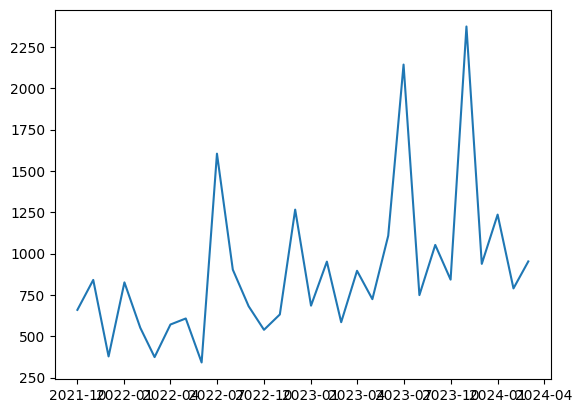

In [137]:
fig, ax = plt.subplots()
ax.plot(df_monthly.y)

In [138]:
adfuller(df_monthly.y)[0:2]

# Već ovdje nema unit root - stationary

(-5.012447492548194, 2.0968112119230055e-05)

In [139]:
# Non-stationary, let's take a first diff
df_monthly.loc[:, "diff1"] = df_monthly.y.diff(1)
df_monthly.head()

,y,ds,diff1
Date,,,
2021-10-01,659.76,2021-10-01,NaN
2021-11-01,840.82,2021-11-01,181.06
2021-12-01,378.26,2021-12-01,-462.56
2022-01-01,825.94,2022-01-01,447.68
2022-02-01,551.60,2022-02-01,-274.34


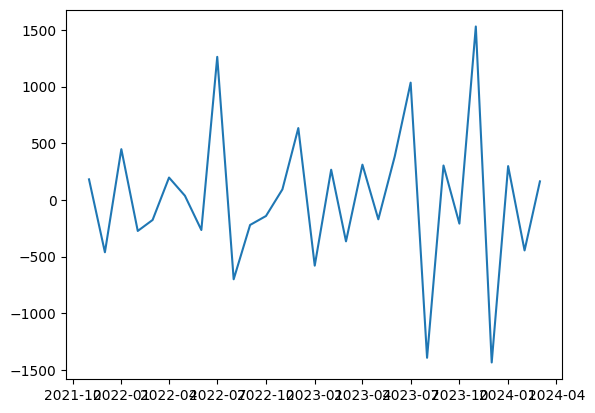

In [140]:
fig, ax = plt.subplots()
ax.plot(df_monthly.diff1)

In [141]:
adfuller(df_monthly.diff1[1:])[0:2]

# NE TREBAJU NAM FIRST DIFF

(-2.0984270470702846, 0.24514756401907317)

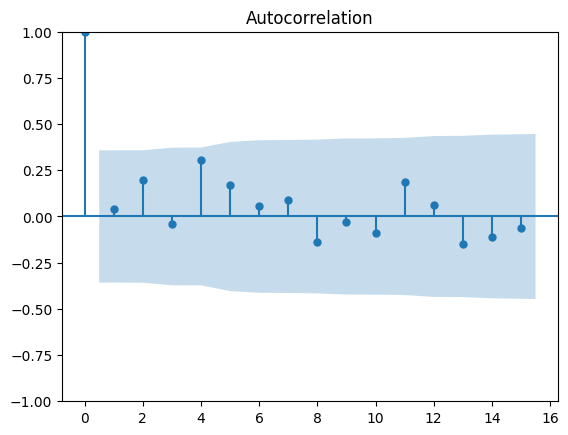

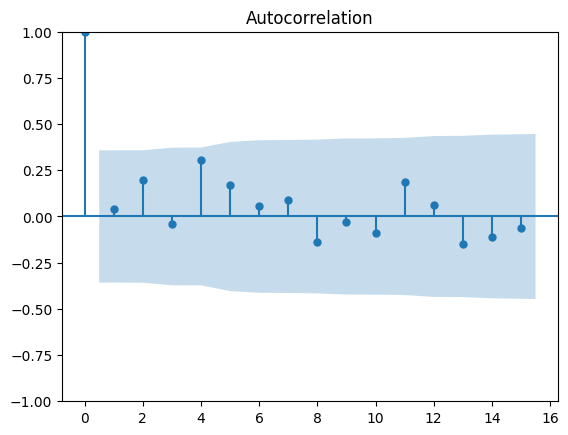

In [142]:
# Pogled na autokorelacije
plot_acf(df_monthly.y)

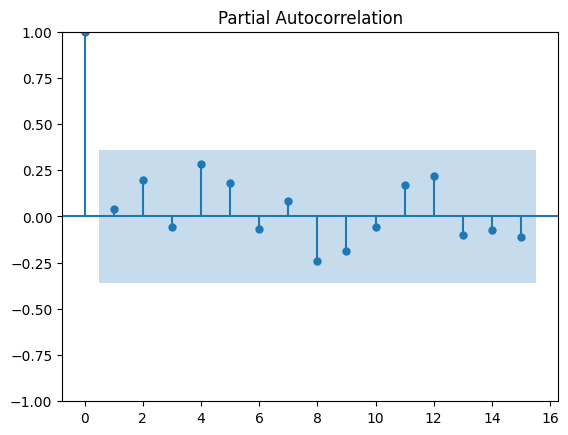

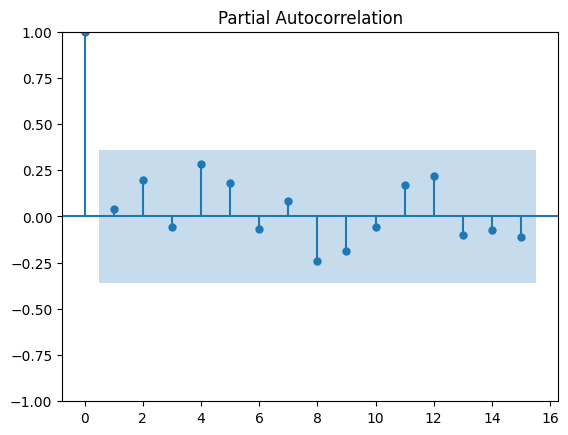

In [143]:
plot_pacf(df_monthly.y)

In [144]:
# nema smisla ARMA model ako nema nikakve autokorelacije.
# Probat ću 2. diff pa vidjet je li stacionaran I ima autokorelacije

df_monthly.loc[:, "diff2"] = df_monthly.diff1.diff(1)
df_monthly

,y,ds,diff1,diff2
Date,,,,
2021-10-01,659.76,2021-10-01,NaN,NaN
2021-11-01,840.82,2021-11-01,181.06,NaN
2021-12-01,378.26,2021-12-01,-462.56,-643.62
2022-01-01,825.94,2022-01-01,447.68,910.24
2022-02-01,551.60,2022-02-01,-274.34,-722.02
2022-03-01,374.27,2022-03-01,-177.33,97.01
2022-04-01,571.23,2022-04-01,196.96,374.29
2022-05-01,607.72,2022-05-01,36.49,-160.47
2022-06-01,341.75,2022-06-01,-265.97,-302.46


In [145]:
adfuller(df_monthly.diff2[2:])[0:2]

(-4.678102790431, 9.249515843470077e-05)

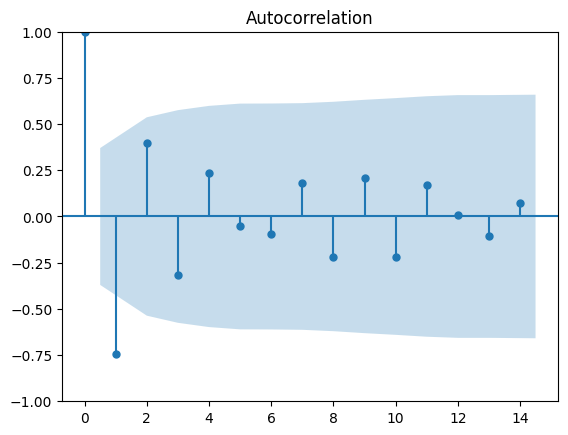

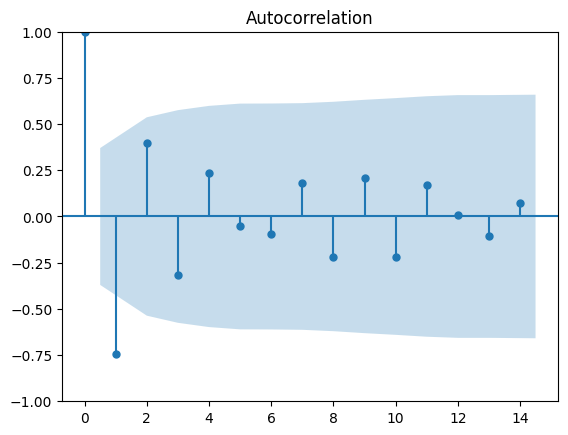

In [146]:
# Stacionarno je, pogledajmo AR
plot_acf(df_monthly.diff2[2:])
# Ovo bih rekao da je sinusoidno, i jedan lag je definitivno značajan

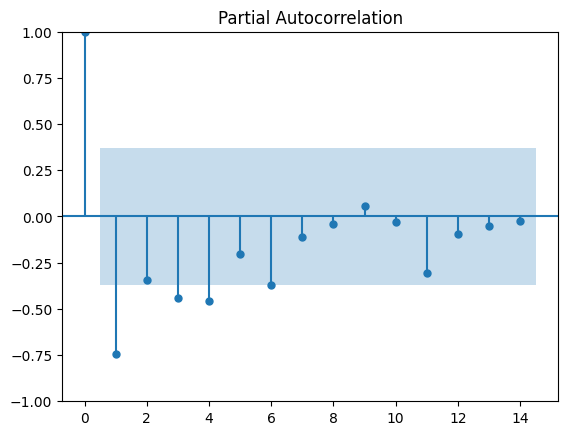

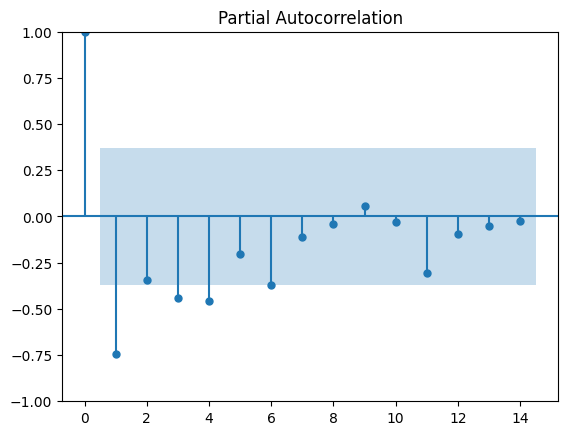

In [147]:
plot_pacf(df_monthly.diff2[2:])

In [148]:
# Ne toliko sinusinoidno, ali ima značajnih lagova. Čini se primjereno za ARMA model.

In [149]:
df = pd.DataFrame({"Value":df_monthly.diff2[2:]})

nrow = df.shape[0]

training_limit = round(0.8 * nrow)

training = df[:training_limit]
testing = df[training_limit:]


horizon = testing.shape[0]
horizon # pola godine!

6

In [150]:
p_ranges = np.arange(0, 5)
q_ranges = np.arange(0, 5)

grid_pq = list(product(p_ranges, q_ranges))
grid_pq

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [151]:
def optimize_ARMA(df, grid):
    results = []

    for grid_pars in grid:
        model = SARIMAX(df.Value, order = (grid_pars[0], 0, grid_pars[1])).fit(disp=False)
        aic = model.aic 

        results.append([grid_pars, aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ["(p, q)", "AIC"]
    # sorting
    results_df = results_df.sort_values(by = "AIC", ascending=True).reset_index(drop=True)

    return results_df



In [152]:
results = optimize_ARMA(df, grid_pq)
results

,"(p, q)",AIC
0,"(0, 2)",434.362730
1,"(0, 3)",435.873680
2,"(1, 2)",435.923119
3,"(3, 2)",437.449440
4,"(4, 1)",438.643898
5,"(1, 3)",438.764990
6,"(2, 4)",439.010899
7,"(3, 1)",439.428779
8,"(1, 4)",439.625553
9,"(2, 3)",439.930110


In [153]:
# 0,2 je zapravo MA model. zanimljivo. ajmo pogledat funkcioniranje

from my_scripts.stat_model_train import recursive_forc_ma, recursive_forc_mean, recursive_forc_last

r_mean = recursive_forc_mean(df, training_limit, horizon, window = 2)
r_last = recursive_forc_last(df, training_limit, horizon, window = 2)

In [154]:
r_ma = recursive_forc_ma(df, training_limit, horizon, window = 2)

In [155]:
testing.loc[:, "last"] = r_last
testing.loc[:, "mean"] = r_mean
testing.loc[:, "MA"] = r_ma


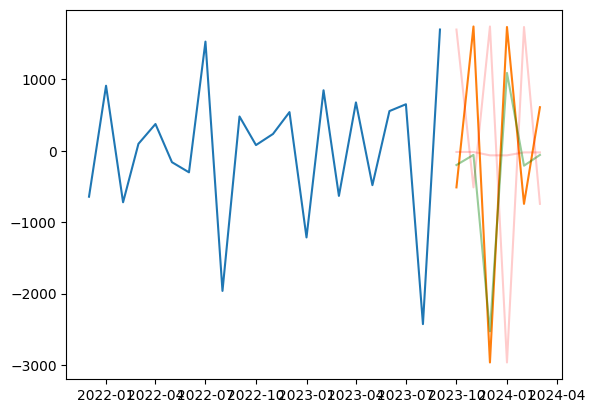

In [156]:
fig, ax = plt.subplots()
ax.plot(training.Value)


ax.plot(testing.Value)

ax.plot(testing["mean"], "r-", alpha = 0.2)
ax.plot(testing["last"], "r-", alpha = 0.2)
ax.plot(testing.MA, "g-", alpha = 0.4)

# Pa čak bih i reko da je OK

In [157]:
# STUCK

# dva retka su nan, pa broj redaka trening seta - 1 (jer indeks počne od nula)


last_diff2 = training.shape[0]  + 2 - 1
last_diff1 = last_diff2
value_diff2 = df_monthly.diff1[last_diff2]
value_diff1 = df_monthly.y[last_diff1]

print(f"diff 2 needs to start from {value_diff2} and 1 from {value_diff1}")

diff 2 needs to start from 303.5000000000001 and 1 from 1052.4


In [158]:
predvidanja = testing.shape[0]

print(f"testing shape {predvidanja}")
prvi_prije = df_monthly.shape[0] - 1 - predvidanja


value_diff2 = df_monthly.diff1[prvi_prije]
value_diff1 = df_monthly.y[prvi_prije]
print(f"diff 2 needs to start from {value_diff2} and 1 from {value_diff1}")

testing shape 6
diff 2 needs to start from 303.5000000000001 and 1 from 1052.4


In [159]:
df_monthly["predicted_last"] = pd.Series()
df_monthly["predicted_MA"] = pd.Series()

df_monthly["predicted_last_diff2"] = testing["last"]
df_monthly["predicted_MA_diff2"] = testing["MA"]
df_monthly.tail(10)

,y,ds,diff1,diff2,predicted_last,predicted_MA,predicted_last_diff2,predicted_MA_diff2
Date,,,,,,,,
2023-06-01,1108.14,2023-06-01,383.70,555.26,NaN,NaN,NaN,NaN
2023-07-01,2142.70,2023-07-01,1034.56,650.86,NaN,NaN,NaN,NaN
2023-08-01,748.90,2023-08-01,-1393.80,-2428.36,NaN,NaN,NaN,NaN
2023-09-01,1052.40,2023-09-01,303.50,1697.30,NaN,NaN,NaN,NaN
2023-10-01,842.60,2023-10-01,-209.80,-513.30,NaN,NaN,1697.30,-200.253091
2023-11-01,2373.00,2023-11-01,1530.40,1740.20,NaN,NaN,-513.30,-58.191052
2023-12-01,937.80,2023-12-01,-1435.20,-2965.60,NaN,NaN,1740.20,-2528.744189
2024-01-01,1235.74,2024-01-01,297.94,1733.14,NaN,NaN,-2965.60,1089.846237
2024-02-01,789.50,2024-02-01,-446.24,-744.18,NaN,NaN,1733.14,-209.530758


In [160]:
def dediff(list):
    dediff = value_diff1 + value_diff2 + np.cumsum(list)
    return dediff

In [161]:
dediff(testing["last"])

Date
2023-10-01    3053.20
2023-11-01    2539.90
2023-12-01    4280.10
2024-01-01    1314.50
2024-02-01    3047.64
2024-03-01    2303.46
Freq: MS, Name: last, dtype: float64

In [162]:
def dediff_2(list):
    dediff_to_1 = value_diff2 + np.cumsum(list)
    dediff_to_original = value_diff1 + np.cumsum(dediff_to_1)
    return dediff_to_original

In [163]:
1697 - 2428 + 1034

303

In [164]:
df_monthly["predicted_last"] = dediff_2(testing["last"])
df_monthly["predicted_MA"] = dediff_2(testing["MA"])
df_monthly.tail(10)

,y,ds,diff1,diff2,predicted_last,predicted_MA,predicted_last_diff2,predicted_MA_diff2
Date,,,,,,,,
2023-06-01,1108.14,2023-06-01,383.70,555.26,NaN,NaN,NaN,NaN
2023-07-01,2142.70,2023-07-01,1034.56,650.86,NaN,NaN,NaN,NaN
2023-08-01,748.90,2023-08-01,-1393.80,-2428.36,NaN,NaN,NaN,NaN
2023-09-01,1052.40,2023-09-01,303.50,1697.30,NaN,NaN,NaN,NaN
2023-10-01,842.60,2023-10-01,-209.80,-513.30,3053.20,1155.646909,1697.30,-200.253091
2023-11-01,2373.00,2023-11-01,1530.40,1740.20,4540.70,1200.702765,-513.30,-58.191052
2023-12-01,937.80,2023-12-01,-1435.20,-2965.60,7768.40,-1282.985567,1740.20,-2528.744189
2024-01-01,1235.74,2024-01-01,297.94,1733.14,8030.50,-2676.827663,-2965.60,1089.846237
2024-02-01,789.50,2024-02-01,-446.24,-744.18,10025.74,-4280.200517,1733.14,-209.530758


In [165]:
dediff_2(testing["Value"])

Date
2023-10-01     842.60
2023-11-01    2373.00
2023-12-01     937.80
2024-01-01    1235.74
2024-02-01     789.50
2024-03-01     952.70
Freq: MS, Name: Value, dtype: float64

In [166]:
def inverse_diff(series, last_observation):

    series_undifferenced = series.copy()

    series_undifferenced.iat[0] = series_undifferenced.iat[0] + last_observation

    series_undifferenced = series_undifferenced.cumsum()

    return series_undifferenced

inverse_diff(inverse_diff(testing["last"], value_diff2), value_diff1)

Date
2023-10-01     3053.20
2023-11-01     4540.70
2023-12-01     7768.40
2024-01-01     8030.50
2024-02-01    10025.74
2024-03-01    11276.80
Freq: MS, Name: last, dtype: float64

In [167]:

inverse_diff(inverse_diff(testing["Value"], value_diff2), value_diff1)

Date
2023-10-01     842.60
2023-11-01    2373.00
2023-12-01     937.80
2024-01-01    1235.74
2024-02-01     789.50
2024-03-01     952.70
Freq: MS, Name: Value, dtype: float64